# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparation du jeu de données](#init)
    * [1.1 Séparation du jeu de données en `train`, `valid` et `test` sets](#NLP_split)
    * [1.2 Création du Corpus Bag-Of-Words](#NLP_corpus_bow)
    * [1.3 Création du Corpus TF-IDF](#NLP_corpus_tfidf)
* [2. Recherche du `modèle` de classification le plus adapté](#CLF)
    * [2.1 DummyClassifier](#CLF_dummy)
    * [2.2 LogisticRegression](#CLF_logreg)
* [3. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [3.1 Tokenisation](#PREPROCESS_tokenized)
    * [3.2 Tokenisation + Filtrage](#PREPROCESS_filtered)
    * [3.3 Tokenisation + Filtrage + Lemmatisation](#PREPROCESS_lemmatized)
    * [3.4 Comparaison des scores](#PREPROCESS_scores)
* [4. Recherche du `plongement` le plus adapté](#EMBEDDING)

In [1]:
import time
import pathlib
import pandas as pd
import numpy as np

import joblib

random_seed = 0
np.random.seed(random_seed)

---
---
# 1. Préparation du jeu de données <a class="anchor" id="init"></a> [⇪](#menu)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder

def preprocess_data(data_nlp, col_name='lemmas', test_size=0.2):
    
    # Target encoding (NOT required anymore with the prepared dataset)
    # label_encoder = LabelEncoder()
    # targets = label_encoder.fit_transform(data_nlp.target)

    # Split the dataset
    df_train, df_test, y_train, y_test = train_test_split(data_nlp[col_name], data_nlp.target, test_size=test_size, random_state=random_seed)
    print(f"DataFrames shapes >> df_train: {df_train.shape}, df_test:{df_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")

    # Prepare corpus for train & test sets
    corpus_train = [" ".join(x) for x in df_train]
    corpus_test = [" ".join(x) for x in df_test]
    print(f"Corpus preview: {corpus_train[:2]}")

    # Prepare TF-IDF 
    tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5, max_features=2000)
    X_train = tfidf_vectorizer_train.fit_transform(corpus_train)
    X_test = tfidf_vectorizer_train.transform(corpus_test)
    
    print(f"TF-IDF features: {tfidf_vectorizer_train.get_feature_names_out()}")
    print(f"Sets shapes >> X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, tfidf_vectorizer_train

### Chargeons le jeu de données brut (RAW) pour nos premiers essais

In [3]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
data_nlp = joblib.load(data_nlp_path)

In [4]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_raw,target
1180586,"[OMG, YES, YES, YES,, DEGRASSI'S, ON, AND, IM,...",1
1471360,"[@martyndarkly, And, it's, an, excuse, to, get...",1


(500000, 2)

In [5]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)

DataFrames shapes >> df_train: (400000,), df_test:(100000,), y_train:(400000,), y_test:(100000,)
Corpus preview: ["@majestyjoseph Everything's gonna be fine.. You just have to believe in yourself and especially to Our Creator.. Have faith!", '@SamlovesRiver I know. Awesome right']
TF-IDF features: ['00' '000' '09' ... 'yum' 'yummy' 'yup']
Sets shapes >> X_train: (400000, 2000), X_test: (100000, 2000)


---
---
# 2. Recherche d'un modèle de classification <a class="anchor" id="CLF"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [6]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_classique.csv")

#### Définissons une méthode de `cross-validation`

In [7]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

## 2.1 Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="CLF_dummy"></a> [⇪](#menu)

In [8]:
from sklearn.dummy import DummyClassifier

In [9]:
model_name = "DummyClassifier (RAW + TF-IDF)"

In [10]:
grd_dummy = fit_model( 
    DummyClassifier(),
    param_grid={ 'random_state':[random_seed], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
    X_ref = X_train,
    y_ref = y_train,
)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5001
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4988
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5006
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5030
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4990

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5003 (std:0.0015)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- DummyClassifier (RAW + TF-IDF) -----------------------------------------------------------------

             ROC_AUC : 0.5000
                  F1 : 0.5011
            ACCURACY : 0.5000
           PRECISION : 0.5004
              RECALL : 0.5018
   AVERAGE_PRECISION : 0.5004

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.50      0.50      0.50     49964
Prediction = 1       0.50      0.50      0.50     50036

      accuracy                           0.50    100000
     macro avg       0.50      0.50      0.50    100000
  weighted avg       0.50  

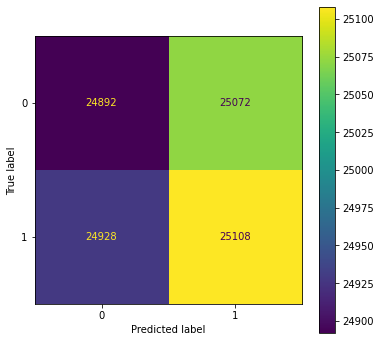

--- ROC AUC ---------------------------------------------------------------------------------------- 



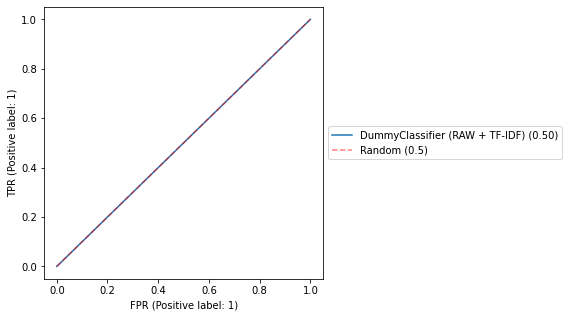

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



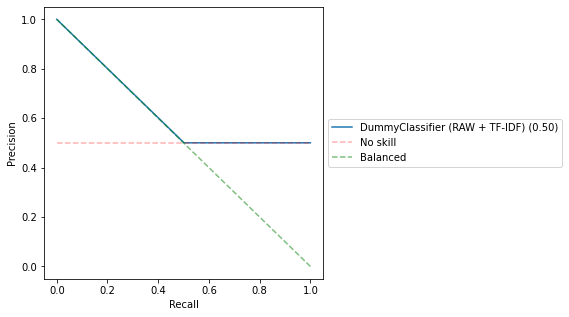

In [11]:
get_scores(model_name, **grd_dummy, register=True, X_ref=X_test, y_ref=y_test)

In [12]:
del grd_dummy

## 2.2 Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="CLF_logreg"></a> [⇪](#menu)

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
from scipy.stats import uniform, loguniform

In [15]:
max_lr_iter = 3000
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [16]:
model_name = "LogisticRegression (RAW + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7990
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7965
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7979
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7986
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7968

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7978 (std:0.0010)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (RAW + TF-IDF) --------------------------------------------------------------

             ROC_AUC : 0.8587
                  F1 : 0.7807
            ACCURACY : 0.7781
           PRECISION : 0.7724
              RECALL : 0.7892
   AVERAGE_PRECISION : 0.8584

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.77      0.78     49964
Prediction = 1       0.77      0.79      0.78     50036

      accuracy                           0.78    100000
     macro avg       0.78      0.78      0.78    100000
  weighted avg       0.78  

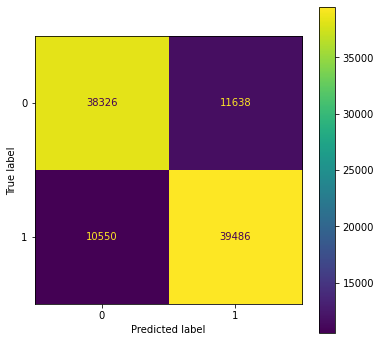

--- ROC AUC ---------------------------------------------------------------------------------------- 



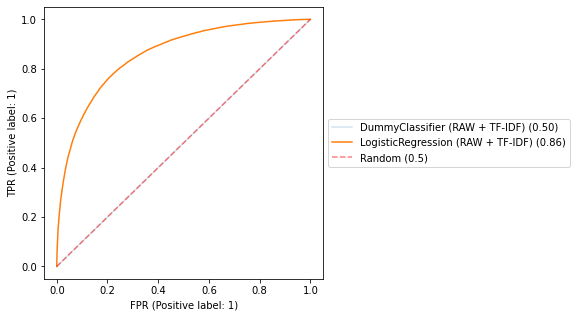

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



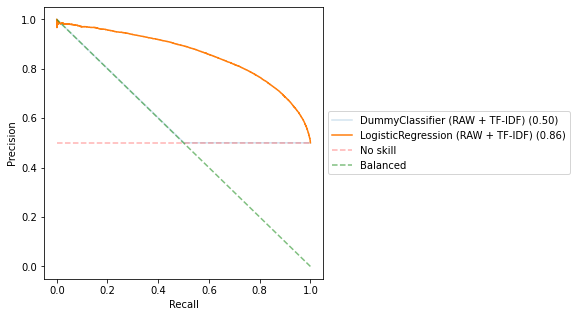

In [17]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
---
# 3. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

---
## 3.1 TOKENISATION <a class="anchor" id="PREPROCESS_tokenized"></a> [⇪](#menu)

### Nous avons déjà calculé ce modèle, donc nous n'allons pas le refaire, mais nous pouvons afficher les résultats une seconde fois

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (RAW + TF-IDF) --------------------------------------------------------------

             ROC_AUC : 0.8587
                  F1 : 0.7807
            ACCURACY : 0.7781
           PRECISION : 0.7724
              RECALL : 0.7892
   AVERAGE_PRECISION : 0.8584

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.77      0.78     49964
Prediction = 1       0.77      0.79      0.78     50036

      accuracy                           0.78    100000
     macro avg       0.78      0.78      0.78    100000
  weighted avg       0.78  

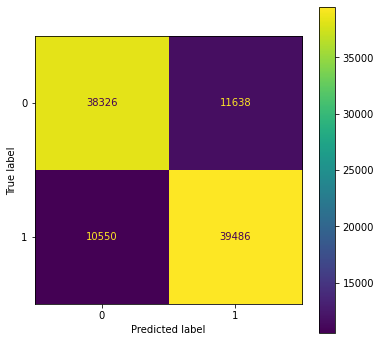

--- ROC AUC ---------------------------------------------------------------------------------------- 



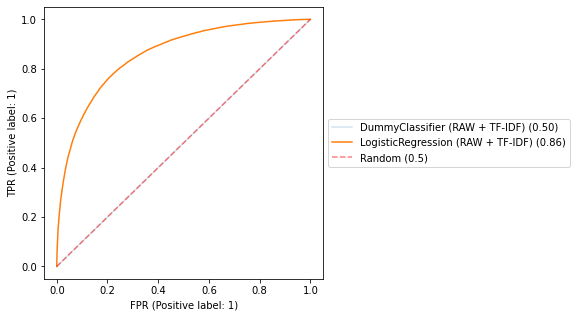

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



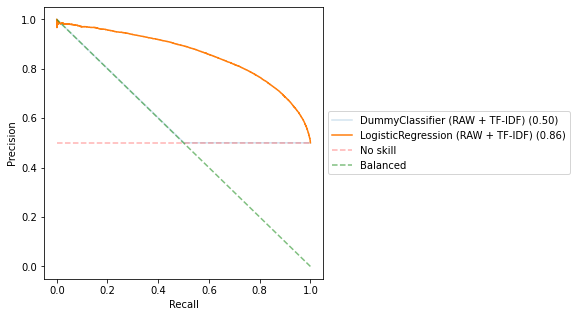

In [18]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.2 TOKENISATION + FILTRAGE <a class="anchor" id="PREPROCESS_filtered"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré

In [19]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_filtered.bin')
data_nlp = joblib.load(data_nlp_path)

In [20]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_filtered,target
1180586,"[omg, yes, yes, yes, watching]",1
1471360,"[excuse, wii]",1


(456560, 2)

In [21]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_nlp, 'tokens_filtered', test_size=0.2)

DataFrames shapes >> df_train: (365248,), df_test:(91312,), y_train:(365248,), y_test:(91312,)
Corpus preview: ['starting feel good promised deliver stuff cob today', 'sad coz join frenz picnic']
TF-IDF features: ['able' 'access' 'accident' ... 'yum' 'yummy' 'yup']
Sets shapes >> X_train: (365248, 2000), X_test: (91312, 2000)


### Appliquons la Logistic Regression avec ce jeu de données

In [22]:
model_name = "LogisticRegression (FILTERED + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7670
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7648
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7670
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7641
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7667

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7659 (std:0.0013)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (FILTERED + TF-IDF) ---------------------------------------------------------

             ROC_AUC : 0.8236
                  F1 : 0.7499
            ACCURACY : 0.7448
           PRECISION : 0.7291
              RECALL : 0.7720
   AVERAGE_PRECISION : 0.8142

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.76      0.72      0.74     46044
Prediction = 1       0.73      0.77      0.75     45268

      accuracy                           0.74     91312
     macro avg       0.75      0.74      0.74     91312
  weighted avg       0.75  

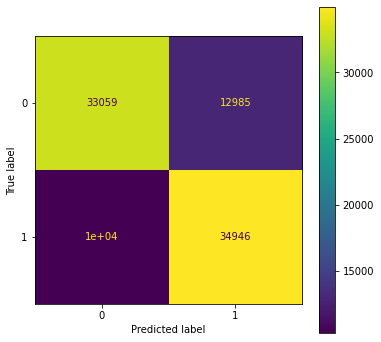

--- ROC AUC ---------------------------------------------------------------------------------------- 



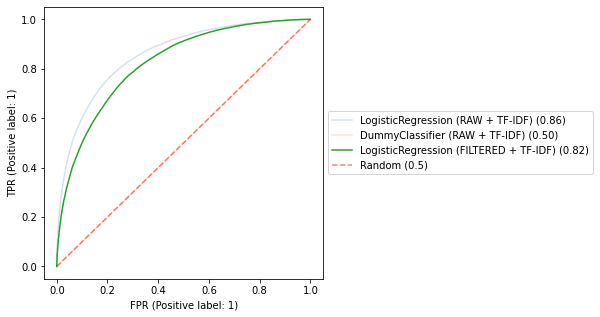

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



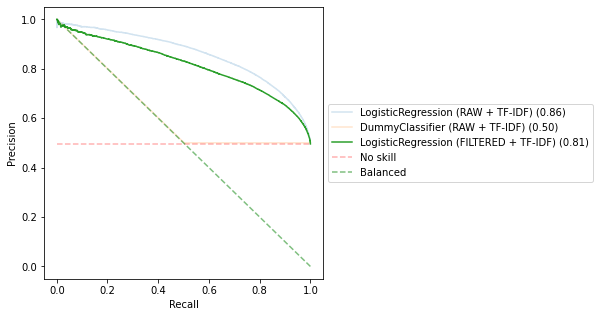

In [23]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.3 TOKENISATION + FILTRAGE + LEMMATIZATION <a class="anchor" id="PREPROCESS_lemmatized"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré & lemmatisé

In [24]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_lemmas.bin')
data_nlp_lemmas = joblib.load(data_nlp_path)

In [25]:
display(data_nlp_lemmas.head(2), data_nlp_lemmas.shape)

,lemmas,target
1180586,"[omg, yes, yes, yes, watch]",1
1471360,"[excuse, wii]",1


(456560, 2)

In [26]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_nlp_lemmas, 'lemmas', test_size=0.2)

DataFrames shapes >> df_train: (365248,), df_test:(91312,), y_train:(365248,), y_test:(91312,)
Corpus preview: ['start feel good promise deliver stuff cob today', 'sad coz join frenz picnic']
TF-IDF features: ['able' 'accept' 'access' ... 'zero' 'zone' 'zoo']
Sets shapes >> X_train: (365248, 2000), X_test: (91312, 2000)


### Appliquons la Logistic Regression avec ce jeu de données

In [27]:
model_name = "LogisticRegression (LEMMATIZED + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7682
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7662
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7685
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7655
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7686

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7674 (std:0.0013)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (LEMMATIZED + TF-IDF) -------------------------------------------------------

             ROC_AUC : 0.8224
                  F1 : 0.7458
            ACCURACY : 0.7417
           PRECISION : 0.7280
              RECALL : 0.7646
   AVERAGE_PRECISION : 0.8136

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.76      0.72      0.74     46044
Prediction = 1       0.73      0.76      0.75     45268

      accuracy                           0.74     91312
     macro avg       0.74      0.74      0.74     91312
  weighted avg       0.74  

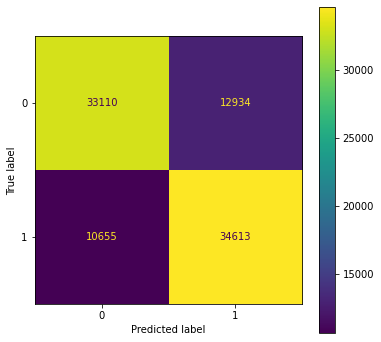

--- ROC AUC ---------------------------------------------------------------------------------------- 



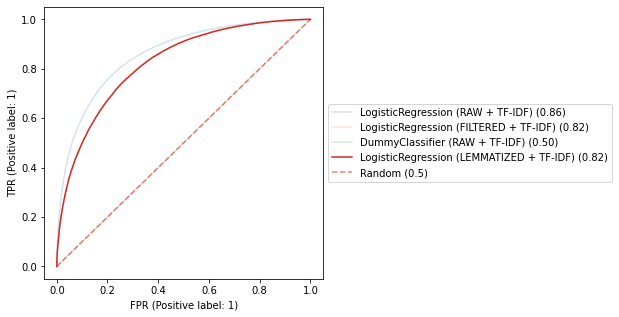

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



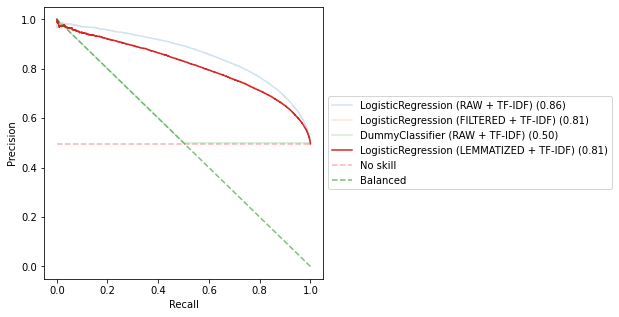

In [28]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.4 Comparaison des `scores` <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [29]:
from classification_utils import scores_df

In [30]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier (RAW + TF-IDF),None,"{'random_state': [0], 'strategy': ['stratified']}",0.499999,0.500359,0.501078,0.500000,0.500359,0.501799,25108,24892,25072,24928,1.745066,0.010112
1,LogisticRegression (RAW + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.858721,0.858362,0.780664,0.778120,0.772357,0.789152,39486,38326,11638,10550,107.280647,0.007766
2,LogisticRegression (FILTERED + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.823638,0.814198,0.749922,0.744754,0.729090,0.771980,34946,33059,12985,10322,66.211569,0.006252
3,LogisticRegression (LEMMATIZED + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.822374,0.813577,0.745849,0.741666,0.727974,0.764624,34613,33110,12934,10655,60.018501,0.005397


# 4. Plongements

> https://fr.wikipedia.org/wiki/Word_embedding
>
> Pour utiliser les données en apprentissage machine, il est nécessaire de leur trouver une représentation mathématique, typiquement des vecteurs. Certaines données s'y prêtent directement, comme par exemple les images, qui engendrent des vecteurs riches en information, encodant toutes les nuances et les couleurs qui les composent. Les mots, quant à eux, sont des éléments d'information isolés, et certaines représentations rudimentaires se limitent à un simple identifiant par mot. Par exemple le mot « chat » sera encodé par un seul identifiant arbitraire, disons X87. C'est une représentation discrète, relativement pauvre, qui ne permet notamment pas de comparer deux mots entre eux5. Les plongements lexicaux, eux, représentent un mot par un vecteur. Par exemple, un chat sera représenté par le vecteur [0,43 0,88 0,98 1,3]. Si l'on encode tous les mots d'un dictionnaire ainsi, il devient alors **possible de comparer les vecteurs des mots entre eux**, par exemple en mesurant l'angle entre les vecteurs. Une bonne représentation de mots permettra alors de trouver que le mot « chien » est plus près du mot « chat » qu'il ne l'est du mot « gratte-ciel »6. Qui plus est, ces représentations permettent d'espérer que, dans l'espace vectoriel où le plongement est fait, on aura l'équation roi - homme + femme = reine ou encore l'équation Paris - France + Pologne = Varsovie7.
> 
> Les plongements lexicaux sont également très **utiles pour mitiger le fléau de la dimension**, un problème récurrent en intelligence artificielle. Sans les plongements de mots, **les identifiants uniques représentant les mots engendrent des données éparses**, des points isolés dans un espace vaste et presque vide6. Avec les plongements de mots, en revanche, l'espace devient beaucoup plus restreint et il est plus facile pour un ordinateur d'y établir des regroupements, d'y découvrir des régularités, en apprentissage machine. 

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder

def preprocess_data_NN(data_nlp, col_name='lemmas', test_size=0.2):
    
    # Target encoding (NOT required anymore with the prepared dataset)
    # label_encoder = LabelEncoder()
    # targets = label_encoder.fit_transform(data_nlp.target)

    # Split the dataset
    df_train, df_test, y_train, y_test = train_test_split(data_nlp[col_name], data_nlp.target, test_size=test_size, random_state=random_seed)
    print(f"DataFrames shapes >> df_train: {df_train.shape}, df_test:{df_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")
    
    return df_train, df_test, y_train, y_test

    # Prepare corpus for train & test sets
    #corpus_train = [" ".join(x) for x in df_train]
    #corpus_test = [" ".join(x) for x in df_test]
    #print(f"Corpus preview: {corpus_train[:2]}")

    # Prepare TF-IDF 
    #tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5, max_features=2000)
    #X_train = tfidf_vectorizer_train.fit_transform(corpus_train)
    #X_test = tfidf_vectorizer_train.transform(corpus_test)
    
    #print(f"TF-IDF features: {tfidf_vectorizer_train.get_feature_names_out()}")
    #print(f"Sets shapes >> X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    #return X_train, X_test, y_train, y_test, tfidf_vectorizer_train

In [54]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_lemmas.bin')
data_nlp = joblib.load(data_nlp_path)

In [55]:
display(data_nlp.head(2), data_nlp.shape)

,lemmas,target
1180586,"[omg, yes, yes, yes, watch]",1
1471360,"[excuse, wii]",1


(456560, 2)

In [221]:
df_train, df_test, y_train, y_test = preprocess_data_NN(data_nlp[:10000], 'lemmas', test_size=0.2)

DataFrames shapes >> df_train: (8000,), df_test:(2000,), y_train:(8000,), y_test:(2000,)


In [72]:
from gensim.models import Word2Vec, FastText

In [222]:
w2v_model = Word2Vec(df_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [229]:
pretrained_weights = w2v_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in w2v_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in w2v_model.wv.most_similar(word)[:8])
        print(f'{word} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

Result embedding shape: (1293, 256)
Checking similar words:
good -> busy (0.35), great (0.35), brilliant (0.33), bad (0.29), blame (0.28), awesome (0.27), cloudy (0.27), report (0.27)
bad -> awful (0.34), n (0.33), rough (0.32), crazy (0.30), lonely (0.30), delicious (0.29), horrible (0.29), good (0.29)
sad -> vacation (0.40), depress (0.39), cry (0.39), mix (0.32), pal (0.32), answer (0.32), hubby (0.32), die (0.32)
⚠️ fabulous is not in the Word2Vec vocabulary
⚠️ difficult is not in the Word2Vec vocabulary
easy -> cleaning (0.41), door (0.41), sync (0.39), key (0.39), possible (0.39), relax (0.38), schedule (0.37), yard (0.36)
boring -> left (0.38), rainy (0.37), spend (0.36), door (0.35), fast (0.35), thunder (0.33), degree (0.33), term (0.32)
fun -> market (0.35), spread (0.32), hang (0.32), productive (0.31), bug (0.30), hollywood (0.30), swear (0.30), crappy (0.29)


In [ ]:
ft_model = FastText(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [231]:
def word_embedding_transform(embedding_model, sentences, max_len=50):

    print('\nPreparing the data for Keras NN...')
    train_x = np.zeros([len(sentences), max_len], dtype=np.int32)
    for i, (id,sentence) in enumerate(sentences.iteritems()):
        for t, word in enumerate(sentence[:-1]):
            if word in embedding_model.wv:
                train_x[i, t] = w2v_model.wv.key_to_index[word]
                
    return train_x

In [232]:
train_x = word_embedding_transform(w2v_model, df_train)
train_y = y_train

print('train_x shape:', train_x.shape, 'train_y shape:', train_y.shape)

valid_x = word_embedding_transform(w2v_model, df_test)
valid_y = y_test

print('valid_x shape:', valid_x.shape, 'valid_y shape:', valid_y.shape)


Preparing the data for Keras NN...
train_x shape: (8000, 50) train_y shape: (8000,)

Preparing the data for Keras NN...
valid_x shape: (2000, 50) valid_y shape: (2000,)


In [233]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [234]:
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

In [328]:
def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=6,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

In [329]:
def architecture1(f_opti, f_loss, f_metrics, embedding=None):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    if embedding is None:
        x = layers.Embedding(vocab_size, 256)(inputs)
    else:
        x = embedding(inputs)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [330]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()

w2v_embedding = gensim_to_keras_embedding(w2v_model, train_embeddings=False)

In [331]:
archi1_model = architecture1(f_opti, f_loss, f_metrics, w2v_embedding)

In [332]:
archi1_model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_25 (Embedding)    (None, None, 256)         331008    
                                                                 
 dropout_58 (Dropout)        (None, None, 256)         0         
                                                                 
 conv1d_58 (Conv1D)          (None, None, 128)         229504    
                                                                 
 conv1d_59 (Conv1D)          (None, None, 128)         114816    
                                                                 
 global_max_pooling1d_29 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                          

In [333]:
history_clf_archi1 = archi1_model.fit(x=train_x, y=train_y, validation_data=(valid_x, valid_y), epochs=50, batch_size=32, callbacks=init_callbacks("archi1")) # , validation_split=0.2 , train_labels

Epoch 1/50
245/250 [============================>.] - ETA: 0s - loss: 0.6993 - accuracy: 0.5034
Epoch 1: val_accuracy improved from -inf to 0.50550, saving model to models/archi1.epoch01-accuracy0.51.hdf5
250/250 [==============================] - 3s 10ms/step - loss: 0.6990 - accuracy: 0.5044 - val_loss: 0.6911 - val_accuracy: 0.5055 - lr: 5.0000e-04
Epoch 2/50
244/250 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.5922
Epoch 2: val_accuracy improved from 0.50550 to 0.63000, saving model to models/archi1.epoch02-accuracy0.63.hdf5
250/250 [==============================] - 2s 10ms/step - loss: 0.6607 - accuracy: 0.5918 - val_loss: 0.6392 - val_accuracy: 0.6300 - lr: 5.0000e-04
Epoch 3/50
249/250 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.6578
Epoch 3: val_accuracy did not improve from 0.63000
250/250 [==============================] - 2s 10ms/step - loss: 0.6133 - accuracy: 0.6576 - val_loss: 0.6348 - val_accuracy: 0.6170 - lr: 5.00